In [14]:
from pyspark.sql import functions as F

# Stop current Spark session
try:
    spark.stop()
except:
    pass

from pyspark.sql import SparkSession

# Give Spark way more memory since you have 32GB RAM available
spark = SparkSession.builder \
    .appName("TimeSeriesForecast") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "16") \
    .config("spark.default.parallelism", "8") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print("Spark restarted with 12GB driver and executor memory")

# Read data
df = spark.read.parquet('../notebooks/data/train.parquet')
df.show(2)
print(f"Total rows: {df.count()}")

Spark restarted with 12GB driver and executor memory
+----+------+------+--------------------+----------+---------+-----+-----------+-------+----------+----------+--------------------+----------------+--------------+---------------+--------------+-----------+------------+-----+----+-------------+
|type| state|  city|              family|      date|store_nbr|sales|onpromotion|cluster|is_holiday|dcoilwtico|       hash_features|strIndxer_family|strIndxer_city|strIndxer_state|strIndxer_type|day_of_week|day_of_month|month|year|is_salary_day|
+----+------+------+--------------------+----------+---------+-----+-----------+-------+----------+----------+--------------------+----------------+--------------+---------------+--------------+-----------+------------+-----+----+-------------+
|   D| Azuay|Cuenca|SCHOOL AND OFFICE...|2013-01-01|       37|  0.0|          0|      2|         1|     93.14|(1024,[124,560,79...|              27|            14|             15|             4|          3|      

In [15]:
# 1. Start with RAW data
df_raw = df

# 2. CREATE LAG FEATURES FIRST (on full data!)
from pyspark.sql.window import Window

window_store_family = Window.partitionBy("store_nbr", "family").orderBy("date")
window_7d = Window.partitionBy("store_nbr", "family").orderBy("date").rowsBetween(-7, -1)
window_14d = Window.partitionBy("store_nbr", "family").orderBy("date").rowsBetween(-14, -1)

print("Creating lag features...")
df_with_lags = df_raw \
    .withColumn("sales_lag_7", F.lag("sales", 7).over(window_store_family)) \
    .withColumn("sales_lag_14", F.lag("sales", 14).over(window_store_family)) \
    .withColumn("sales_lag_30", F.lag("sales", 30).over(window_store_family)) \
    .withColumn("sales_rolling_mean_7", F.avg("sales").over(window_7d)) \
    .withColumn("sales_rolling_mean_14", F.avg("sales").over(window_14d)) \
    .withColumn("sales_rolling_std_7", F.stddev("sales").over(window_7d)) \
    .withColumn("promo_rolling_sum_7", F.sum("onpromotion").over(window_7d))

# Add date features
df_with_lags = df_with_lags \
    .withColumn("week_of_year", F.weekofyear("date")) \
    .withColumn("quarter", F.quarter("date")) \
    .withColumn("is_weekend", F.when(F.col("day_of_week").isin([5, 6]), 1).otherwise(0)) \
    .withColumn("is_month_start", F.when(F.dayofmonth("date") <= 5, 1).otherwise(0)) \
    .withColumn("is_month_end", F.when(F.dayofmonth("date") >= 25, 1).otherwise(0))

# 3. NOW find stable periods
window_14d_density = Window.partitionBy("store_nbr", "family").orderBy("date").rowsBetween(-13, 0)

df_with_density = df_with_lags.withColumn(
    "sales_days_in_window",
    F.sum(F.when(F.col("sales") > 0, 1).otherwise(0)).over(window_14d_density)
)

stable_starts = df_with_density.filter(F.col("sales_days_in_window") >= 7) \
    .groupBy("store_nbr", "family") \
    .agg(F.min("date").alias("stable_start_date"))

# 4. Filter to stable periods
df_with_stable = df_with_lags.join(
    stable_starts.select("store_nbr", "family", "stable_start_date"), 
    on=["store_nbr", "family"], 
    how="inner"
)

df_stable = df_with_stable.filter(F.col("date") >= F.col("stable_start_date"))

# 5. Require sufficient data
sufficient_data = df_stable.groupBy("store_nbr", "family").agg(
    F.countDistinct("date").alias("stable_days"),
    F.sum("sales").alias("total_sales")
).filter(
    (F.col("stable_days") >= 365) &
    (F.col("total_sales") >= 0)
)

df_trainable = df_stable.join(
    sufficient_data.select("store_nbr", "family"),
    on=["store_nbr", "family"],
    how="inner"
).drop("stable_start_date", "sales_days_in_window")

print(f"Trainable rows: {df_trainable.count():,}")

# 6. Verify lag features exist
print("\nVerifying lag features:")
for col in ['sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7']:
    if col in df_trainable.columns:
        null_count = df_trainable.filter(F.col(col).isNull()).count()
        print(f"✓ {col}: {null_count:,} nulls")
    else:
        print(f"❌ {col}: MISSING!")

Creating lag features...


Trainable rows: 2,369,333

Verifying lag features:


✓ sales_lag_7: 15 nulls


✓ sales_lag_14: 5,849 nulls


✓ sales_rolling_mean_7: 0 nulls


In [16]:
df = df_trainable.filter(F.col('family').isin(['HOME AND KITCHEN I', 'PRODUCE']))
df.show(2)
df.columns

+---------+------------------+----+---------+-----+----------+-----+-----------+-------+----------+----------+--------------------+----------------+--------------+---------------+--------------+-----------+------------+-----+----+-------------+-----------+------------+------------+--------------------+---------------------+-------------------+-------------------+------------+-------+----------+--------------+------------+
|store_nbr|            family|type|    state| city|      date|sales|onpromotion|cluster|is_holiday|dcoilwtico|       hash_features|strIndxer_family|strIndxer_city|strIndxer_state|strIndxer_type|day_of_week|day_of_month|month|year|is_salary_day|sales_lag_7|sales_lag_14|sales_lag_30|sales_rolling_mean_7|sales_rolling_mean_14|sales_rolling_std_7|promo_rolling_sum_7|week_of_year|quarter|is_weekend|is_month_start|is_month_end|
+---------+------------------+----+---------+-----+----------+-----+-----------+-------+----------+----------+--------------------+----------------+

['store_nbr',
 'family',
 'type',
 'state',
 'city',
 'date',
 'sales',
 'onpromotion',
 'cluster',
 'is_holiday',
 'dcoilwtico',
 'hash_features',
 'strIndxer_family',
 'strIndxer_city',
 'strIndxer_state',
 'strIndxer_type',
 'day_of_week',
 'day_of_month',
 'month',
 'year',
 'is_salary_day',
 'sales_lag_7',
 'sales_lag_14',
 'sales_lag_30',
 'sales_rolling_mean_7',
 'sales_rolling_mean_14',
 'sales_rolling_std_7',
 'promo_rolling_sum_7',
 'week_of_year',
 'quarter',
 'is_weekend',
 'is_month_start',
 'is_month_end']

In [17]:
df_trainable.select(['store_nbr', 'family', 'date', 'sales', 'sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7']).show(15)

+---------+------+----------+-----+-----------+------------+--------------------+
|store_nbr|family|      date|sales|sales_lag_7|sales_lag_14|sales_rolling_mean_7|
+---------+------+----------+-----+-----------+------------+--------------------+
|        1|BEAUTY|2013-01-10|  3.0|        0.0|        NULL|  1.5714285714285714|
|        1|BEAUTY|2013-01-11|  2.0|        3.0|        NULL|                 2.0|
|        1|BEAUTY|2013-01-12|  0.0|        3.0|        NULL|  1.8571428571428572|
|        1|BEAUTY|2013-01-13|  0.0|        0.0|        NULL|  1.4285714285714286|
|        1|BEAUTY|2013-01-14|  2.0|        1.0|        NULL|  1.4285714285714286|
|        1|BEAUTY|2013-01-15|  0.0|        3.0|         0.0|  1.5714285714285714|
|        1|BEAUTY|2013-01-16|  2.0|        1.0|         2.0|  1.1428571428571428|
|        1|BEAUTY|2013-01-17|  2.0|        3.0|         0.0|  1.2857142857142858|
|        1|BEAUTY|2013-01-18|  4.0|        2.0|         3.0|  1.1428571428571428|
|        1|BEAUT

In [18]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# IMPORTANT: Work with a manageable sample first
df_sample = df.sample(fraction=0.1, seed=42)  # Use 10% of data
print(f"Sample size: {df_sample.count()}")

# Define feature columns (only the most important ones to reduce memory)
feature_cols = ['strIndxer_family',
    'onpromotion', 'is_holiday', 'day_of_week', 'month', 'year',
    'sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7',
    'promo_rolling_sum_7', 'week_of_year', 'is_weekend'
]

# Keep only existing columns
feature_cols = [col for col in feature_cols if col in df_sample.columns]

# Remove nulls
df_clean = df_sample.select(['date', 'sales'] + feature_cols).na.drop()

# Repartition to reduce memory pressure
df_clean = df_clean.repartition(4)

print(f"Clean sample size: {df_clean.count()}")

# Assemble features
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

df_assembled = assembler.transform(df_clean)
df_assembled.show(5)

# Get date range
dates = df_assembled.agg(F.min("date"), F.max("date")).collect()[0]
print(f"Date range: {dates[0]} to {dates[1]}")

# Simple date split
train_df = df_assembled.limit(int(df_assembled.count() * 0.8))
test_df = df_assembled.subtract(train_df)

print(f"Train: {train_df.count()}, Test: {test_df.count()}")

# Use Random Forest (lighter than GBT)
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="sales",
    numTrees=20,  # Reduced from default
    maxDepth=5,   # Reduced depth
    seed=42
)

print("\nTraining model...")
model = rf.fit(train_df)

# Predict
predictions = model.transform(test_df)

# Evaluate
evaluator = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

evaluator_mae = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

print(f"\n=== Results on 10% Sample ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Show sample predictions
predictions.select("date", "sales", "prediction").show(10)

Sample size: 14033


Clean sample size: 14085


+----------+-------+----------------+-----------+----------+-----------+-----+----+-----------+------------+--------------------+-------------------+------------+----------+--------------------+
|      date|  sales|strIndxer_family|onpromotion|is_holiday|day_of_week|month|year|sales_lag_7|sales_lag_14|sales_rolling_mean_7|promo_rolling_sum_7|week_of_year|is_weekend|            features|
+----------+-------+----------------+-----------+----------+-----------+-----+----+-----------+------------+--------------------+-------------------+------------+----------+--------------------+
|2015-01-16|    0.0|               0|          0|         0|          6|    1|2015|        0.0|         0.0|                 0.0|                  0|           3|         1|(12,[3,4,5,10,11]...|
|2016-04-24|   16.0|               1|          0|         1|          1|    4|2016|        8.0|         6.0|  30.142857142857142|                  0|          16|         0|[1.0,0.0,1.0,1.0,...|
|2016-09-07|   14.0|     

Date range: 2013-03-22 to 2017-08-15


Train: 11268, Test: 2605

Training model...



=== Results on 10% Sample ===
RMSE: 561.84
MAE: 202.07


+----------+-------+------------------+
|      date|  sales|        prediction|
+----------+-------+------------------+
|2017-07-17|904.321|1266.5996570411476|
|2013-12-31|    0.0|130.22699593621053|
|2014-07-31|   53.0|30.543710497556127|
|2014-12-31|   35.0|  42.8883697956284|
|2017-08-13|   37.0|35.013577846852634|
|2017-05-20|   42.0|33.068884883205385|
|2016-08-19|   21.0| 29.67135227515762|
|2014-09-29|   11.0| 31.04711474045508|
|2013-05-24|   52.0| 71.60549717506488|
|2016-05-07|   13.0|28.349005505310267|
+----------+-------+------------------+
only showing top 10 rows


In [19]:
from pyspark.sql import functions as F

print("="*60)
print("GRANULARITY ANALYSIS")
print("="*60)

# Total rows
total_rows = df.count()
print(f"\nTotal rows: {total_rows:,}")

# Test different combinations
print("\nTesting unique combinations:")

# 1. Date level
date_count = df.select("date").distinct().count()
print(f"  Unique dates: {date_count:,}")

# 2. Date + Store
date_store = df.select("date", "store_nbr").distinct().count()
print(f"  Unique (date, store_nbr): {date_store:,}")

# 3. Date + Family
date_family = df.select("date", "family").distinct().count()
print(f"  Unique (date, family): {date_family:,}")

# 4. Date + Store + Family (likely the grain)
date_store_family = df.select("date", "store_nbr", "family").distinct().count()
print(f"  Unique (date, store_nbr, family): {date_store_family:,}")

print("\n" + "="*60)

# Determine granularity
if date_store_family == total_rows:
    print("✓ GRANULARITY: One row per (date, store_nbr, family)")
    print("  This means: Daily sales for each product family at each store")
else:
    print(f"⚠️  DUPLICATES DETECTED!")
    print(f"  Expected unique combinations: {date_store_family:,}")
    print(f"  Actual rows: {total_rows:,}")
    print(f"  Duplicate rows: {total_rows - date_store_family:,}")
    
    # Show example duplicates
    print("\nSample duplicates:")
    df.groupBy("date", "store_nbr", "family").count() \
      .filter(F.col("count") > 1) \
      .orderBy(F.desc("count")) \
      .show(5)

# Show store attributes relationship
print("\n" + "="*60)
print("STORE ATTRIBUTES (should be many-to-one with store_nbr):")
print("="*60)

store_attrs = df.select("store_nbr", "type", "state", "city").distinct()
store_count = df.select("store_nbr").distinct().count()
store_attrs_count = store_attrs.count()

print(f"Unique stores: {store_count}")
print(f"Unique (store, type, state, city) combos: {store_attrs_count}")

if store_count == store_attrs_count:
    print("✓ Each store has one unique (type, state, city)")
else:
    print("⚠️  Some stores have multiple type/state/city values")

# Sample data structure
print("\n" + "="*60)
print("SAMPLE DATA:")
print("="*60)
df.select("date", "store_nbr", "family", "sales", "type", "city", "state", "cluster").show(10, truncate=False)

GRANULARITY ANALYSIS



Total rows: 140,316

Testing unique combinations:


  Unique dates: 1,604


  Unique (date, store_nbr): 73,741


  Unique (date, family): 2,918


  Unique (date, store_nbr, family): 140,316

✓ GRANULARITY: One row per (date, store_nbr, family)
  This means: Daily sales for each product family at each store

STORE ATTRIBUTES (should be many-to-one with store_nbr):


Unique stores: 53
Unique (store, type, state, city) combos: 53
✓ Each store has one unique (type, state, city)

SAMPLE DATA:
+----------+---------+------------------+-----+----+-----+---------+-------+
|date      |store_nbr|family            |sales|type|city |state    |cluster|
+----------+---------+------------------+-----+----+-----+---------+-------+
|2014-01-08|4        |HOME AND KITCHEN I|23.0 |D   |Quito|Pichincha|9      |
|2014-01-23|4        |HOME AND KITCHEN I|4.0  |D   |Quito|Pichincha|9      |
|2014-01-25|4        |HOME AND KITCHEN I|27.0 |D   |Quito|Pichincha|9      |
|2014-01-10|4        |HOME AND KITCHEN I|18.0 |D   |Quito|Pichincha|9      |
|2014-01-30|4        |HOME AND KITCHEN I|23.0 |D   |Quito|Pichincha|9      |
|2014-01-13|4        |HOME AND KITCHEN I|11.0 |D   |Quito|Pichincha|9      |
|2014-01-22|4        |HOME AND KITCHEN I|11.0 |D   |Quito|Pichincha|9      |
|2014-01-18|4        |HOME AND KITCHEN I|19.0 |D   |Quito|Pichincha|9      |
|2014-01-28|4        |HOME A

In [20]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Feature columns (excluding family since we're grouping by it)


feature_cols = [
 'onpromotion',
 'cluster',
 'is_holiday',
 'dcoilwtico',
#  'hash_features',
 'strIndxer_family',
 'strIndxer_city',
 'strIndxer_state',
 'strIndxer_type',
 'day_of_week',
 'day_of_month',
 'month',
 'year',
 'is_salary_day',
 'sales_lag_7',
 'sales_lag_14',
 'sales_lag_30',
 'sales_rolling_mean_7',
 'sales_rolling_mean_14',
 'sales_rolling_std_7',
 'promo_rolling_sum_7',
 'week_of_year',
 'quarter',
 'is_weekend',
 'is_month_start',
 'is_month_end']

# feature_cols = [
#     'onpromotion', 'is_holiday', 'day_of_week', 'month', 'year',
#     'sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7',
#     'promo_rolling_sum_7', 'week_of_year', 'is_weekend',
#     'strIndxer_city', 'strIndxer_state', 'strIndxer_type', 'cluster'
#     # Note: NOT including strIndxer_family since we're training per family
# ]

feature_cols = [col for col in feature_cols if col in df.columns]

# Get unique families
families = df.select("family").distinct().rdd.flatMap(lambda x: x).collect()
print(f"Training models for {len(families)} families")

# Dictionary to store models and metrics
models = {}
metrics = []

# Get date range for splitting
dates = df.agg(F.min("date"), F.max("date")).collect()[0]
split_date = dates[0] + (dates[1] - dates[0]) * 0.8

for family in families:
    print(f"\n{'='*50}")
    print(f"Training model for: {family}")
    print(f"{'='*50}")
    
    # Filter data for this family
    df_family = df.filter(F.col("family") == family)
    
    # Check if sufficient data
    count = df_family.count()
    if count < 1000:  # Skip if too little data
        print(f"Skipping {family} - insufficient data ({count} rows)")
        continue
    
    print(f"Rows: {count}")
    
    # Clean and prepare features
    df_clean = df_family.select(['date', 'sales'] + feature_cols).na.drop()
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_assembled = assembler.transform(df_clean)
    
    # Time-based split
    train_df = df_assembled.filter(F.col("date") < split_date).cache()
    test_df = df_assembled.filter(F.col("date") >= split_date).cache()
    
    train_count = train_df.count()
    test_count = test_df.count()
    print(f"Train: {train_count}, Test: {test_count}")
    
    if train_count < 100 or test_count < 10:
        print(f"Skipping {family} - insufficient train/test data")
        train_df.unpersist()
        test_df.unpersist()
        continue
    
    # Train model
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="sales",
        numTrees=30,
        maxDepth=6,
        seed=42
    )
    
    try:
        model = rf.fit(train_df)
        
        # Predict
        predictions = model.transform(test_df)
        
        # Evaluate
        evaluator_rmse = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="rmse")
        evaluator_mae = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="mae")
        evaluator_r2 = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="r2")
        
        rmse = evaluator_rmse.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)
        
        print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")
        
        # Store results
        models[family] = model
        metrics.append({
            'family': family,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'train_rows': train_count,
            'test_rows': test_count
        })
        
        # Save model
        # model.write().overwrite().save(f"/Volumes/portfolio_catalog/databricks_pipeline/models/rf_sales_{family.replace(' ', '_')}")
        
    except Exception as e:
        print(f"Error training model for {family}: {e}")
    
    finally:
        train_df.unpersist()
        test_df.unpersist()


Training models for 2 families



Training model for: HOME AND KITCHEN I


Rows: 66756


Train: 49690, Test: 17066
RMSE: 90.51, MAE: 28.42, R²: -4.1238

Training model for: PRODUCE


Rows: 73560


Train: 56494, Test: 17066
RMSE: 625.77, MAE: 340.68, R²: 0.9350


In [21]:

# Summary of all models
print(f"\n{'='*50}")
print("SUMMARY OF ALL MODELS")
print(f"{'='*50}")

import pandas as pd
metrics_df = pd.DataFrame(metrics).sort_values('r2')
print(metrics_df.to_string(index=False))

print(f"\nAverage RMSE: {metrics_df['rmse'].mean():.2f}")
print(f"Average MAE: {metrics_df['mae'].mean():.2f}")
print(f"Average R²: {metrics_df['r2'].mean():.4f}")
    
# Save metrics
metrics_df.to_csv('./model_metrics_families_all_periods.csv', index=False)
print(f"\n✓ Metrics saved to ./model_metrics_families_all_periods.csv")


SUMMARY OF ALL MODELS
            family       rmse        mae        r2  train_rows  test_rows
HOME AND KITCHEN I  90.505281  28.417402 -4.123831       49690      17066
           PRODUCE 625.767549 340.675633  0.934969       56494      17066

Average RMSE: 358.14
Average MAE: 184.55
Average R²: -1.5944

✓ Metrics saved to ./model_metrics_families_all_periods.csv


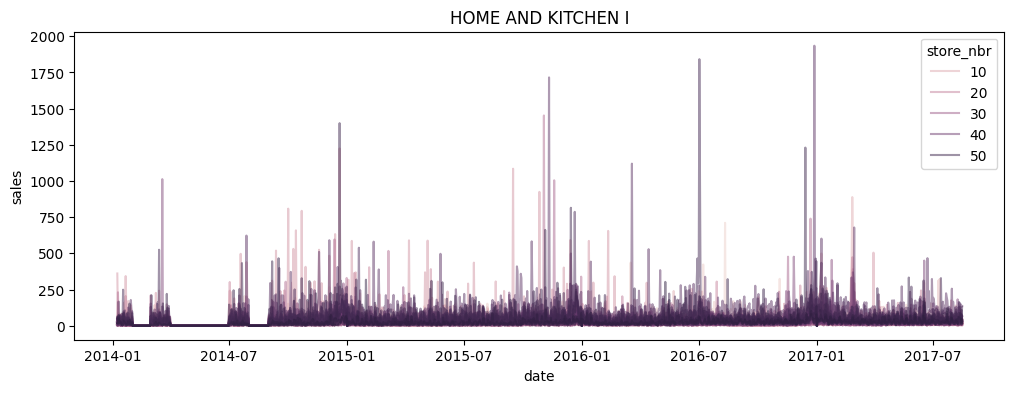

In [22]:
dfx = df.filter(F.col('family') == 'HOME AND KITCHEN I').groupBy('date', 'store_nbr', 'family').agg(F.sum('sales').alias('sales')).toPandas()
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=dfx, x='date', y='sales', hue='store_nbr', alpha=0.5)
plt.title('HOME AND KITCHEN I');

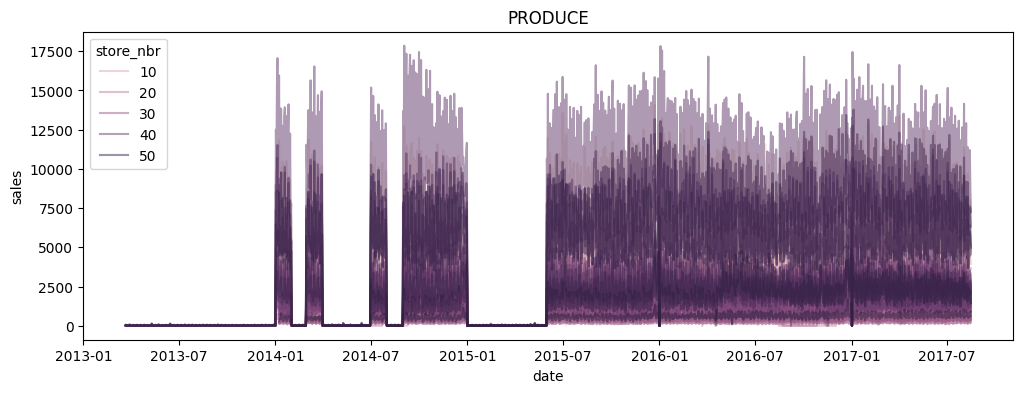

In [23]:
dfx = df.filter(F.col('family') == 'PRODUCE').groupBy('date', 'store_nbr', 'family').agg(F.sum('sales').alias('sales')).toPandas()
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=dfx, x='date', y='sales', hue='store_nbr', alpha=0.5)
plt.title('PRODUCE');

In [24]:
dfx_weekly = (
    dfx
    .assign(date=pd.to_datetime(dfx["date"]))
    .set_index("date")
    .groupby("family")["sales"]
    .resample("W")
    .sum()
    .reset_index()
)


/var/folders/gb/m76n3l_97j92hstc5f4t0ds00000gn/T/ipykernel_33356/1462249806.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


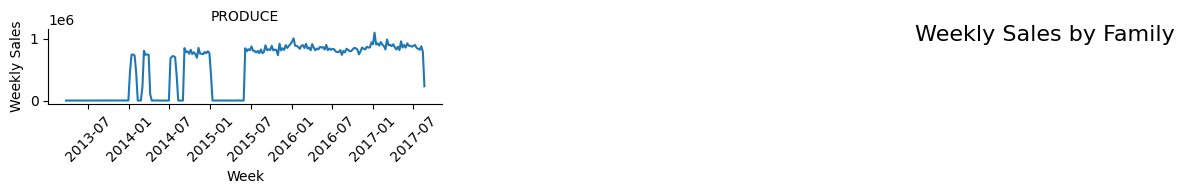

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(
    dfx_weekly,
    col="family",
    col_wrap=5,
    height=1.4,
    aspect=3.0,     # wider figure
    sharex=True,
    sharey=False
)

g.map_dataframe(sns.lineplot, x="date", y="sales")

g.set_titles("{col_name}")
g.set_axis_labels("Week", "Weekly Sales")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Weekly Sales by Family", fontsize=16)

for ax in g.axes.flat:
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


- We have some families that have late-starts, for example this one with sales from 2014. Also some period of no sales in 2014.
- Let's focus on the late-starts as the next step.

In [26]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

# Step 1: Identify first sale date for each store-family combination
store_family_start = df.filter(F.col("sales") > 0).groupBy("store_nbr", "family").agg(
    F.min("date").alias("active_start_date"),
    F.count("*").alias("active_days")
)

print(f"Store-family combinations with sales: {store_family_start.count()}")
store_family_start.show(50)

# Step 2: Join back to main df and filter
df_with_start = df.join(store_family_start, on=["store_nbr", "family"], how="inner")

# Only keep data from active_start_date onwards for each combo
df_active = df_with_start.filter(F.col("date") >= F.col("active_start_date"))

print(f"\nOriginal rows: {df.count():,}")
print(f"Active period rows: {df_active.count():,}")

# Step 3: Filter out combinations with insufficient data
# Require at least 365 days of data for training
sufficient_data = df_active.groupBy("store_nbr", "family").agg(
    F.countDistinct("date").alias("days_count")
).filter(F.col("days_count") >= 365)

print(f"Combinations with >=365 days: {sufficient_data.count()}")

df_trainable = df_active.join(
    sufficient_data.select("store_nbr", "family"),
    on=["store_nbr", "family"],
    how="inner"
).drop("active_start_date", "active_days")

print(f"Final trainable rows: {df_trainable.count():,}")

# Now train models per family as before, but using df_trainable
feature_cols = [
    'onpromotion', 'is_holiday', 'day_of_week', 'month', 'year',
    'sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7',
    'promo_rolling_sum_7', 'week_of_year', 'is_weekend',
    'strIndxer_city', 'strIndxer_state', 'strIndxer_type', 'cluster'
    # Note: NOT including strIndxer_family since we're training per family
]

feature_cols = [col for col in feature_cols if col in df_trainable.columns]

# Get families
families = [row['family'] for row in df_trainable.select("family").distinct().collect()]
print(f"\nTraining models for {len(families)} families")

all_metrics = []
successful_models = 0

for idx, family in enumerate(families, 1):
    print(f"\n{'='*60}")
    print(f"[{idx}/{len(families)}] Training: {family}")
    print(f"{'='*60}")
    
    try:
        # Filter for this family
        df_family = df_trainable.filter(F.col("family") == family)
        
        # For each store-family, we're already using only their active period
        count = df_family.count()
        print(f"Total rows: {count:,}")
        
        if count < 1000:
            print(f"⚠️  Skipping - insufficient data")
            continue
        
        # Clean data
        df_clean = df_family.select(['date', 'sales', 'store_nbr'] + feature_cols).na.drop()
        # df_clean = df_family.select(['date', 'sales'] + feature_cols).na.drop()
        clean_count = df_clean.count()
        print(f"Clean rows: {clean_count:,}")
        
        # Get date range for THIS family's data
        date_range = df_clean.agg(F.min("date"), F.max("date")).collect()[0]
        family_min_date = date_range[0]
        family_max_date = date_range[1]
        
        # Calculate 80/20 split based on THIS family's date range
        date_span = (family_max_date - family_min_date).days
        split_date = family_min_date + pd.Timedelta(days=int(date_span * 0.8))
        
        print(f"Date range: {family_min_date} to {family_max_date}")
        print(f"Split date: {split_date}")
        
        # Assemble features
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        df_assembled = assembler.transform(df_clean)
        
        # Time-based split
        train_df = df_assembled.filter(F.col("date") < split_date).cache()
        test_df = df_assembled.filter(F.col("date") >= split_date).cache()
        
        train_count = train_df.count()
        test_count = test_df.count()
        print(f"Train: {train_count:,} | Test: {test_count:,}")
        
        if train_count < 100 or test_count < 20:
            print(f"⚠️  Skipping - insufficient split data")
            train_df.unpersist()
            test_df.unpersist()
            continue
        
        # Train model
        rf = RandomForestRegressor(
            featuresCol="features",
            labelCol="sales",
            numTrees=50,
            maxDepth=8,
            seed=42
        )
        
        print("Training model...")
        model = rf.fit(train_df)
        
        print("Making predictions...")
        predictions = model.transform(test_df)
        
        # Evaluate
        evaluator_rmse = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="rmse")
        evaluator_mae = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="mae")
        evaluator_r2 = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="r2")
        
        rmse = evaluator_rmse.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)
        
        print(f"✓ Results: RMSE={rmse:.2f} | MAE={mae:.2f} | R²={r2:.4f}")
        
        # Save metrics
        all_metrics.append({
            'family': family,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'train_rows': train_count,
            'test_rows': test_count,
            'date_range_days': date_span
        })
        
        successful_models += 1
        
        # Clean up
        train_df.unpersist()
        test_df.unpersist()
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")



Store-family combinations with sales: 106
+---------+------------------+-----------------+-----------+
|store_nbr|            family|active_start_date|active_days|
+---------+------------------+-----------------+-----------+
|        4|HOME AND KITCHEN I|       2014-01-08|       1158|
|        7|HOME AND KITCHEN I|       2014-01-08|       1156|
|        8|           PRODUCE|       2013-03-26|       1412|
|       10|           PRODUCE|       2014-01-08|       1010|
|       13|HOME AND KITCHEN I|       2014-01-08|       1149|
|       16|HOME AND KITCHEN I|       2014-01-08|       1159|
|       19|HOME AND KITCHEN I|       2014-01-09|       1156|
|       20|           PRODUCE|       2015-06-07|        797|
|       21|HOME AND KITCHEN I|       2015-07-30|        744|
|       24|HOME AND KITCHEN I|       2014-01-08|       1136|
|       29|HOME AND KITCHEN I|       2015-03-26|        870|
|       30|HOME AND KITCHEN I|       2014-01-08|       1148|
|       32|           PRODUCE|       2014-0


Original rows: 140,316


Active period rows: 140,316


Combinations with >=365 days: 106


Final trainable rows: 140,316



Training models for 2 families

[1/2] Training: HOME AND KITCHEN I


Total rows: 66,756


Clean rows: 66,756


Date range: 2014-01-07 to 2017-08-15
Split date: 2016-11-24


Train: 52,764 | Test: 13,992
Training model...


25/12/24 01:15:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
25/12/24 01:15:39 WARN DAGScheduler: Broadcasting large task binary with size 1316.9 KiB
25/12/24 01:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1795.2 KiB
25/12/24 01:15:40 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Making predictions...
✓ Results: RMSE=90.60 | MAE=30.62 | R²=-3.6534

[2/2] Training: PRODUCE


Total rows: 73,560


Clean rows: 73,560


Date range: 2013-03-22 to 2017-08-15
Split date: 2016-09-27


Train: 56,494 | Test: 17,066
Training model...


25/12/24 01:16:08 WARN DAGScheduler: Broadcasting large task binary with size 1067.4 KiB
25/12/24 01:16:08 WARN DAGScheduler: Broadcasting large task binary with size 1317.0 KiB
25/12/24 01:16:08 WARN DAGScheduler: Broadcasting large task binary with size 1801.6 KiB
25/12/24 01:16:09 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Making predictions...
✓ Results: RMSE=597.91 | MAE=315.47 | R²=0.9406


In [27]:
# Final summary
print(f"\n{'='*60}")
print("TRAINING COMPLETE")
print(f"{'='*60}")
print(f"Successfully trained: {successful_models}/{len(families)} models")

if all_metrics:
    metrics_df = pd.DataFrame(all_metrics).sort_values('r2')
    print("\n" + metrics_df.to_string(index=False))
    
    print(f"\n📊 Overall Performance:")
    print(f"   Average RMSE: {metrics_df['rmse'].mean():.2f}")
    print(f"   Average MAE: {metrics_df['mae'].mean():.2f}")
    print(f"   Average R²: {metrics_df['r2'].mean():.4f}")
    
    # Save metrics
    metrics_df.to_csv('./model_metrics_active_periods.csv', index=False)
    print(f"\n✓ Metrics saved to ./model_metrics_active_periods.csv")


TRAINING COMPLETE
Successfully trained: 2/2 models

            family       rmse        mae        r2  train_rows  test_rows  date_range_days
HOME AND KITCHEN I  90.598879  30.623676 -3.653412       52764      13992             1316
           PRODUCE 597.909027 315.466037  0.940630       56494      17066             1607

📊 Overall Performance:
   Average RMSE: 344.25
   Average MAE: 173.04
   Average R²: -1.3564

✓ Metrics saved to ./model_metrics_active_periods.csv


Our average R² increased from 0.4151 to 0.5013.

In [28]:
import os
model_metrics = os.listdir('.')

metrics_dfs = []
for model in model_metrics:
    if model.startswith('model_metrics'):
        print(f"Model metrics: {model}")
        metrics_df = pd.read_csv(model)
        metrics_df['model'] = model.replace('.csv', '')
        metrics_dfs.append(metrics_df)
        # print(metrics_df.to_string(index=False))

metrics_dfs = pd.concat(metrics_dfs)

Model metrics: model_metrics_active_periods.csv
Model metrics: model_metrics_families_all_periods.csv


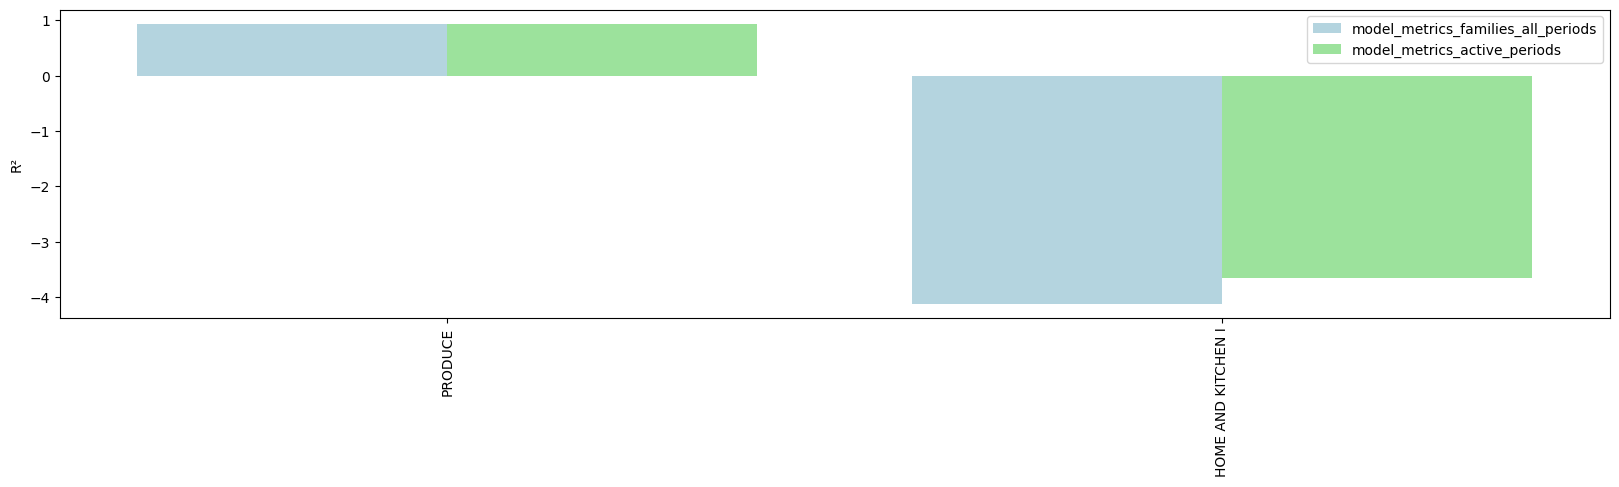

In [29]:
data = (
    metrics_dfs
    .pivot_table(
        index='family',
        columns='model',
        values='r2',
        aggfunc='mean'
    )
    .reset_index()
    .round(2).sort_values('model_metrics_active_periods', ascending=False)
)

long = data.melt(
    id_vars='family',
    value_vars=[
        'model_metrics_families_all_periods',
        'model_metrics_active_periods'
    ],
    var_name='period',
    value_name='r2'
)

fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(
    data=long,
    x='family',
    y='r2',
    hue='period',
    palette=['lightblue', 'lightgreen']
)

plt.xticks(rotation=90)
plt.ylabel('R²')
plt.xlabel('')
plt.legend(title='');

- There are some improvements by removing the late-start periods.
- However, we also noticed there are some issues with large date gaps. Let's try to fix those next.
- And let's focus on HOME AND KITCHEN I

In [30]:
dfx = df.filter(F.col('family') == 'HOME AND KITCHEN I').groupBy('date', 'store_nbr', 'family').agg(F.sum('sales').alias('sales')).toPandas()

dfx_weekly = (
    dfx
    .assign(date=pd.to_datetime(dfx["date"]))
    .groupby(["family", "store_nbr"])  # include store
    .resample("W", on="date")      # resample weekly
    .sales
    .sum()
    .reset_index()
)


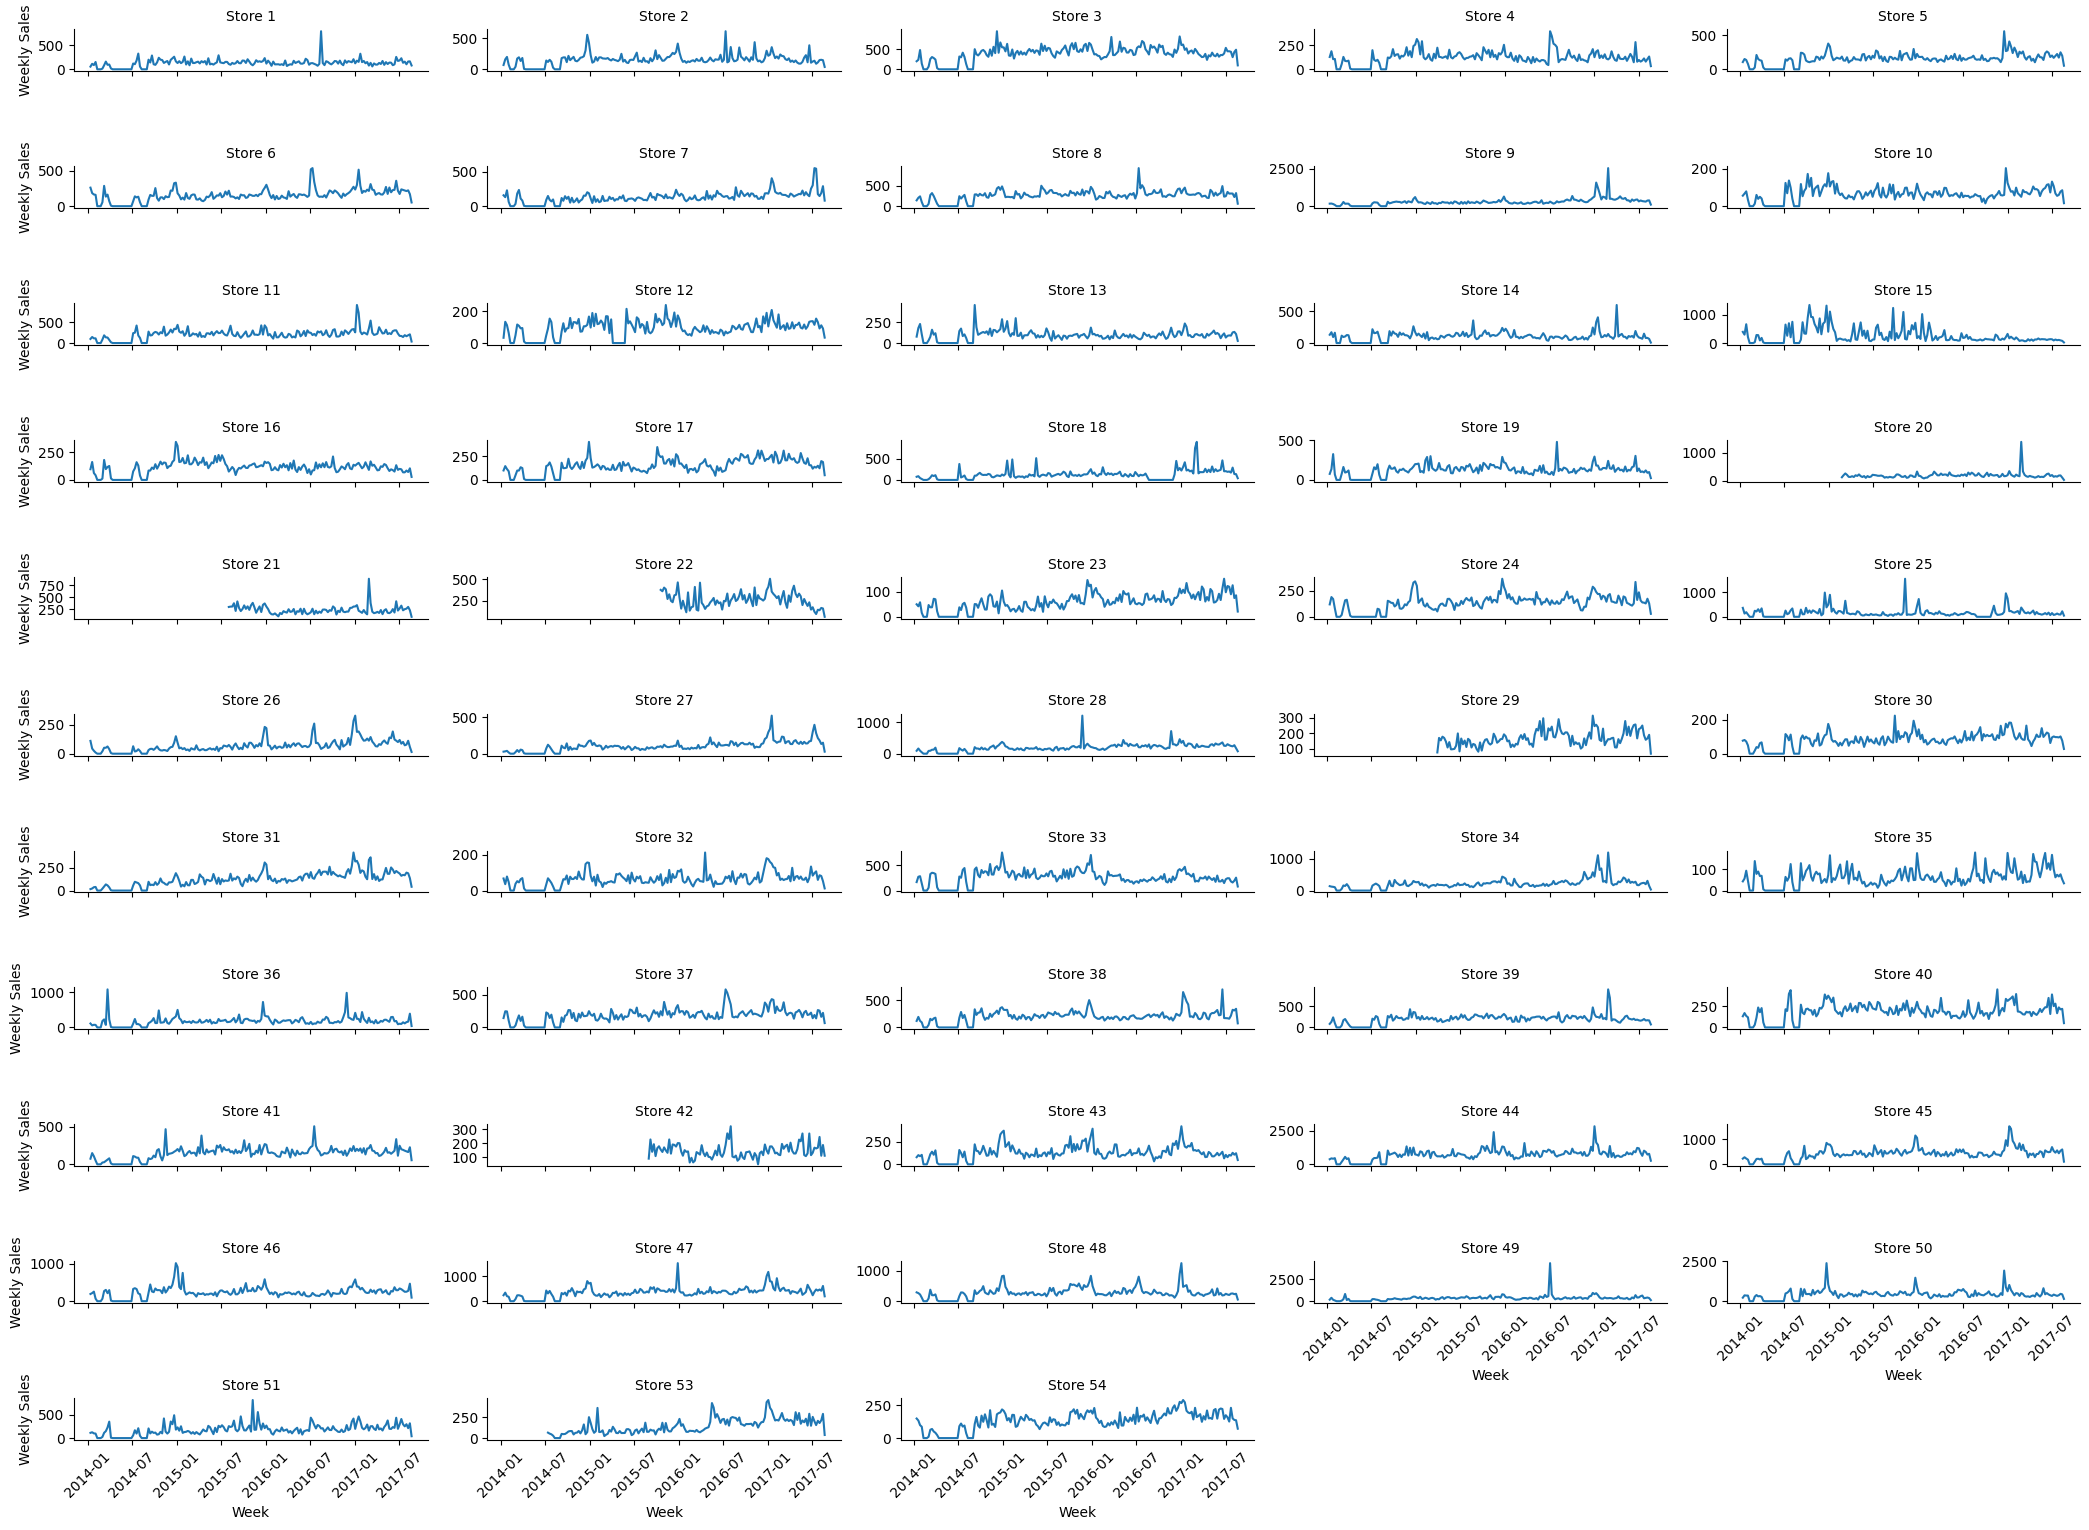

In [31]:

family_name = "HOME AND KITCHEN I"

g = sns.FacetGrid(
    dfx_weekly[dfx_weekly["family"] == family_name],
    col="store_nbr",
    col_wrap=5,
    height=1.4,
    aspect=3.0,
    sharex=True,
    sharey=False
)

g.map_dataframe(sns.lineplot, x="date", y="sales")

g.set_titles("Store {col_name}")
g.set_axis_labels("Week", "Weekly Sales")

for ax in g.axes.flat:
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


There are some stores with late-start after 2015. However, our previous model started from 2014-01-01.


- [19/32] Training: HOME AND KITCHEN I
- Total rows: 67,076
- Clean rows: 67,076
- Date range: 2014-01-01 to 2017-08-15
- Split date: 2016-11-23
- Train: 53,031 | Test: 14,045


In [ ]:
# df = spark.read.parquet('../notebooks/data/train.parquet')
# df = df.filter(F.col('family') == 'HOME AND KITCHEN I')
# df.show(4)

+----+---------+------+------------------+----------+---------+-----+-----------+-------+----------+----------+--------------------+----------------+--------------+---------------+--------------+-----------+------------+-----+----+-------------+
|type|    state|  city|            family|      date|store_nbr|sales|onpromotion|cluster|is_holiday|dcoilwtico|       hash_features|strIndxer_family|strIndxer_city|strIndxer_state|strIndxer_type|day_of_week|day_of_month|month|year|is_salary_day|
+----+---------+------+------------------+----------+---------+-----+-----------+-------+----------+----------+--------------------+----------------+--------------+---------------+--------------+-----------+------------+-----+----+-------------+
|   D|    Azuay|Cuenca|HOME AND KITCHEN I|2013-01-06|       37|  0.0|          0|      2|         0|     93.12|(1024,[21,124,560...|               1|            14|             15|             4|          1|           6|    1|2013|            0|
|   A|Pichincha|

In [33]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Phase 1: Find "stable start date" for each store-family
# Define stable as: at least 7 consecutive days with sales in a 10-day window

window_10d = Window.partitionBy("store_nbr", "family").orderBy("date").rowsBetween(-9, 0)

df_with_density = df.withColumn(
    "sales_in_last_10_days",
    F.sum(F.when(F.col("sales") > 0, 1).otherwise(0)).over(window_10d)
)

# Mark where stable period begins (7+ sales days in last 10 days)
df_stable_flag = df_with_density.withColumn(
    "is_stable",
    F.when(F.col("sales_in_last_10_days") >= 7, 1).otherwise(0)
)

# Get first stable date for each store-family
stable_starts = df_stable_flag.filter(F.col("is_stable") == 1) \
    .groupBy("store_nbr", "family") \
    .agg(F.min("date").alias("stable_start_date"))

print("Sample stable start dates:")
stable_starts.show(54)

# Phase 2: Use only stable period data
df_stable = df.join(stable_starts, on=["store_nbr", "family"], how="inner") \
              .filter(F.col("date") >= F.col("stable_start_date"))

print(f"\nOriginal rows: {df.count():,}")
print(f"Stable period rows: {df_stable.count():,}")

# Phase 3: Require minimum data for training
sufficient_data = df_stable.groupBy("store_nbr", "family").agg(
    F.countDistinct("date").alias("days_count"),
    F.sum("sales").alias("total_sales")
).filter(
    (F.col("days_count") >= 365) &  # At least 1 year of STABLE data
    (F.col("total_sales") >= 0)
)

print(f"Store-family combos with sufficient stable data: {sufficient_data.count()}")

df_trainable = df_stable.join(
    sufficient_data.select("store_nbr", "family"),
    on=["store_nbr", "family"],
    how="inner"
).drop("stable_start_date")

print(f"Final trainable rows: {df_trainable.count():,}")
df_trainable.show(4)

Sample stable start dates:


+---------+------------------+-----------------+
|store_nbr|            family|stable_start_date|
+---------+------------------+-----------------+
|        4|HOME AND KITCHEN I|       2014-01-14|
|        7|HOME AND KITCHEN I|       2014-01-14|
|        8|           PRODUCE|       2013-04-03|
|       10|           PRODUCE|       2014-01-14|
|       13|HOME AND KITCHEN I|       2014-01-14|
|       16|HOME AND KITCHEN I|       2014-01-14|
|       19|HOME AND KITCHEN I|       2014-01-15|
|       20|           PRODUCE|       2015-06-13|
|       21|HOME AND KITCHEN I|       2015-08-05|
|       24|HOME AND KITCHEN I|       2014-01-14|
|       29|HOME AND KITCHEN I|       2015-04-01|
|       30|HOME AND KITCHEN I|       2014-01-14|
|       32|           PRODUCE|       2014-01-14|
|       37|HOME AND KITCHEN I|       2014-01-14|
|       38|HOME AND KITCHEN I|       2014-01-14|
|       41|HOME AND KITCHEN I|       2014-01-14|
|       46|           PRODUCE|       2013-03-30|
|       49|         


Original rows: 140,316


Stable period rows: 139,657


Store-family combos with sufficient stable data: 106


Final trainable rows: 139,657


+---------+------------------+----+---------+-----+----------+-----+-----------+-------+----------+----------+--------------------+----------------+--------------+---------------+--------------+-----------+------------+-----+----+-------------+-----------+------------+------------+--------------------+---------------------+-------------------+-------------------+------------+-------+----------+--------------+------------+
|store_nbr|            family|type|    state| city|      date|sales|onpromotion|cluster|is_holiday|dcoilwtico|       hash_features|strIndxer_family|strIndxer_city|strIndxer_state|strIndxer_type|day_of_week|day_of_month|month|year|is_salary_day|sales_lag_7|sales_lag_14|sales_lag_30|sales_rolling_mean_7|sales_rolling_mean_14|sales_rolling_std_7|promo_rolling_sum_7|week_of_year|quarter|is_weekend|is_month_start|is_month_end|
+---------+------------------+----+---------+-----+----------+-----+-----------+-------+----------+----------+--------------------+----------------+

In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

# feature_cols = [
#     'onpromotion', 'is_holiday', 'day_of_week', 'day_of_month', 'month', 'year',
#     'sales_lag_7', 'sales_lag_14', 'sales_lag_30',
#     'sales_rolling_mean_7', 'sales_rolling_mean_14', 'sales_rolling_std_7',
#     'promo_rolling_sum_7', 'week_of_year', 'quarter', 'is_weekend',
#     'is_month_start', 'is_month_end', 'is_salary_day',
#     'strIndxer_city', 'strIndxer_state', 'strIndxer_type', 'cluster'
# ]

feature_cols = [
 'onpromotion',
 'cluster',
 'is_holiday',
 'dcoilwtico',
#  'hash_features',
 'strIndxer_family',
 'strIndxer_city',
 'strIndxer_state',
 'strIndxer_type',
 'day_of_week',
 'day_of_month',
 'month',
 'year',
 'is_salary_day',
 'sales_lag_7',
 'sales_lag_14',
 'sales_lag_30',
 'sales_rolling_mean_7',
 'sales_rolling_mean_14',
 'sales_rolling_std_7',
 'promo_rolling_sum_7',
 'week_of_year',
 'quarter',
 'is_weekend',
 'is_month_start',
 'is_month_end']


# feature_cols = [
#     'onpromotion', 'is_holiday', 'day_of_week', 'month', 'year',
#     'sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7',
#     'promo_rolling_sum_7', 'week_of_year', 'is_weekend',
#     'strIndxer_city', 'strIndxer_state', 'strIndxer_type', 'cluster'
#     # Note: NOT including strIndxer_family since we're training per family
# ]


feature_cols = [col for col in feature_cols if col in df_trainable.columns]

families = [row['family'] for row in df_trainable.select("family").distinct().collect()]
print(f"\nTraining models for {len(families)} families")

all_metrics = []

for idx, family in enumerate(families, 1):
    print(f"\n{'='*60}")
    print(f"[{idx}/{len(families)}] Training: {family}")
    print(f"{'='*60}")
    
    try:
        df_family = df_trainable.filter(F.col("family") == family)
        count = df_family.count()
        print(f"Total rows (stable periods only): {count:,}")
        
        if count < 1000:
            print(f"⚠️  Skipping - insufficient data")
            continue
        
        # Each store-family is already filtered to its stable period
        # Check date range
        date_range = df_family.agg(F.min("date"), F.max("date")).collect()[0]
        print(f"Date range: {date_range[0]} to {date_range[1]}")
        
        # Clean and prepare
        df_clean = df_family.select(['date', 'sales', 'store_nbr'] + feature_cols).na.drop()
        
        # Calculate split date (80/20)
        date_span = (date_range[1] - date_range[0]).days
        split_date = date_range[0] + pd.Timedelta(days=int(date_span * 0.8))
        print(f"Split date: {split_date}")
        
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        df_assembled = assembler.transform(df_clean)
        
        train_df = df_assembled.filter(F.col("date") < split_date).cache()
        test_df = df_assembled.filter(F.col("date") >= split_date).cache()
        
        train_count = train_df.count()
        test_count = test_df.count()
        print(f"Train: {train_count:,} | Test: {test_count:,}")
        
        if train_count < 100 or test_count < 20:
            print(f"⚠️  Skipping - insufficient split")
            train_df.unpersist()
            test_df.unpersist()
            continue
        
        # Train
        rf = RandomForestRegressor(
            featuresCol="features",
            labelCol="sales",
            numTrees=50,
            maxDepth=8,
            seed=42
        )
        
        model = rf.fit(train_df)
        predictions = model.transform(test_df)
        
        # Evaluate
        rmse = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="rmse").evaluate(predictions)
        mae = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="mae").evaluate(predictions)
        r2 = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="r2").evaluate(predictions)
        
        print(f"✓ RMSE={rmse:.2f} | MAE={mae:.2f} | R²={r2:.4f}")
        
        all_metrics.append({
            'family': family,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'train_rows': train_count,
            'test_rows': test_count
        })
        
        train_df.unpersist()
        test_df.unpersist()
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")

# Summary
if all_metrics:
    metrics_df = pd.DataFrame(all_metrics).sort_values('rmse')
    print("\n" + metrics_df.to_string(index=False))
    print(f"\n📊 Average RMSE: {metrics_df['rmse'].mean():.2f}")
    print(f"📊 Average R²: {metrics_df['r2'].mean():.4f}")
    metrics_df.to_csv('./metrics_stable_periods.csv', index=False)


Training models for 2 families

[1/2] Training: HOME AND KITCHEN I


Total rows (stable periods only): 66,432


Date range: 2014-01-13 to 2017-08-15
Split date: 2016-11-26


Train: 52,546 | Test: 13,886


25/12/24 01:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1034.4 KiB
25/12/24 01:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1293.1 KiB
25/12/24 01:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1781.2 KiB
25/12/24 01:19:16 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


✓ RMSE=84.92 | MAE=29.00 | R²=-3.0672

[2/2] Training: PRODUCE


Total rows (stable periods only): 73,225


Date range: 2013-03-28 to 2017-08-15
Split date: 2016-09-28


Train: 56,212 | Test: 17,013


25/12/24 01:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1033.5 KiB
25/12/24 01:19:39 WARN DAGScheduler: Broadcasting large task binary with size 1295.8 KiB
25/12/24 01:19:39 WARN DAGScheduler: Broadcasting large task binary with size 1808.8 KiB
25/12/24 01:19:39 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


✓ RMSE=584.78 | MAE=310.77 | R²=0.9433

            family       rmse        mae        r2  train_rows  test_rows
HOME AND KITCHEN I  84.924852  28.999464 -3.067180       52546      13886
           PRODUCE 584.784504 310.767602  0.943304       56212      17013

📊 Average RMSE: 334.85
📊 Average R²: -1.0619


In [35]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

feature_cols = [
 'onpromotion',
 'cluster',
 'is_holiday',
 'dcoilwtico',
#  'hash_features',
 'strIndxer_family',
 'strIndxer_city',
 'strIndxer_state',
 'strIndxer_type',
 'day_of_week',
 'day_of_month',
 'month',
 'year',
 'is_salary_day',
 'sales_lag_7',
 'sales_lag_14',
 'sales_lag_30',
 'sales_rolling_mean_7',
 'sales_rolling_mean_14',
 'sales_rolling_std_7',
 'promo_rolling_sum_7',
 'week_of_year',
 'quarter',
 'is_weekend',
 'is_month_start',
 'is_month_end']


# feature_cols = [
#     'onpromotion', 'is_holiday', 'day_of_week', 'month', 'year',
#     'sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7',
#     'promo_rolling_sum_7', 'week_of_year', 'is_weekend',
#     'strIndxer_city', 'strIndxer_state', 'strIndxer_type', 'cluster'
# ]

feature_cols = [col for col in feature_cols if col in df_trainable.columns]
print(f"Available features: {feature_cols}")

families = [row['family'] for row in df_trainable.select("family").distinct().collect()]
print(f"\nTraining models for {len(families)} families")

all_metrics = []
skipped_families = []

for idx, family in enumerate(families, 1):
    print(f"\n{'='*60}")
    print(f"[{idx}/{len(families)}] Training: {family}")
    print(f"{'='*60}")
    
    try:
        df_family = df_trainable.filter(F.col("family") == family)
        count = df_family.count()
        print(f"Total rows (stable periods only): {count:,}")
        
        if count < 1000:
            print(f"⚠️  Skipping - insufficient data")
            skipped_families.append({'family': family, 'reason': 'insufficient_data', 'rows': count})
            continue
        
        # Show sales statistics
        sales_stats = df_family.agg(
            F.min("sales").alias("min_sales"),
            F.avg("sales").alias("avg_sales"),
            F.max("sales").alias("max_sales"),
            F.stddev("sales").alias("std_sales")
        ).collect()[0]
        
        print(f"Sales stats: min={sales_stats['min_sales']:.1f}, avg={sales_stats['avg_sales']:.1f}, "
              f"max={sales_stats['max_sales']:.1f}, std={sales_stats['std_sales']:.1f}")
        
        # Check date range
        date_range = df_family.agg(F.min("date"), F.max("date")).collect()[0]
        print(f"Date range: {date_range[0]} to {date_range[1]}")
        
        # Clean and prepare
        df_clean = df_family.select(['date', 'sales', 'store_nbr'] + feature_cols).na.drop()
        clean_count = df_clean.count()
        print(f"After dropping nulls: {clean_count:,} rows ({100*clean_count/count:.1f}%)")
        
        if clean_count < 1000:
            print(f"⚠️  Skipping - too many nulls")
            skipped_families.append({'family': family, 'reason': 'too_many_nulls', 'rows': clean_count})
            continue
        
        # Calculate split date (80/20)
        date_span = (date_range[1] - date_range[0]).days
        split_date = date_range[0] + pd.Timedelta(days=int(date_span * 0.8))
        print(f"Split date: {split_date} ({date_span} days total)")
        
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        df_assembled = assembler.transform(df_clean)
        
        train_df = df_assembled.filter(F.col("date") < split_date).cache()
        test_df = df_assembled.filter(F.col("date") >= split_date).cache()
        
        train_count = train_df.count()
        test_count = test_df.count()
        print(f"Train: {train_count:,} | Test: {test_count:,}")
        
        if train_count < 100 or test_count < 20:
            print(f"⚠️  Skipping - insufficient split")
            skipped_families.append({'family': family, 'reason': 'insufficient_split', 
                                    'train': train_count, 'test': test_count})
            train_df.unpersist()
            test_df.unpersist()
            continue
        
        # Train
        rf = RandomForestRegressor(
            featuresCol="features",
            labelCol="sales",
            numTrees=50,
            maxDepth=8,
            seed=42
        )
        
        print("Training model...")
        model = rf.fit(train_df)
        
        print("Making predictions...")
        predictions = model.transform(test_df)
        
        # Show sample predictions
        sample_preds = predictions.select("date", "sales", "prediction").orderBy("date").limit(10)
        print("\nSample predictions:")
        sample_preds.show(10, truncate=False)
        
        # Evaluate
        rmse = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="rmse").evaluate(predictions)
        mae = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="mae").evaluate(predictions)
        r2 = RegressionEvaluator(labelCol="sales", predictionCol="prediction", metricName="r2").evaluate(predictions)
        
        # Calculate additional metrics
        pred_stats = predictions.agg(
            F.avg("prediction").alias("avg_pred"),
            F.stddev("prediction").alias("std_pred")
        ).collect()[0]
        
        print(f"\n✓ Results:")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  MAE: {mae:.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Avg actual sales: {sales_stats['avg_sales']:.1f}")
        print(f"  Avg predicted sales: {pred_stats['avg_pred']:.1f}")
        
        # Feature importance
        feature_importances = model.featureImportances.toArray()
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': feature_importances
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 5 features:")
        for _, row in importance_df.head(5).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
        
        all_metrics.append({
            'family': family,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'train_rows': train_count,
            'test_rows': test_count,
            'avg_sales': sales_stats['avg_sales'],
            'avg_prediction': pred_stats['avg_pred']
        })
        
        train_df.unpersist()
        test_df.unpersist()
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        import traceback
        traceback.print_exc()
        skipped_families.append({'family': family, 'reason': 'error', 'error': str(e)})

# Summary
print(f"\n{'='*60}")
print("FINAL SUMMARY")
print(f"{'='*60}")

if all_metrics:
    metrics_df = pd.DataFrame(all_metrics).sort_values('r2', ascending=False)
    print("\n" + metrics_df.to_string(index=False))
    
    print(f"\n📊 Performance Statistics:")
    print(f"   Average RMSE: {metrics_df['rmse'].mean():.2f}")
    print(f"   Average MAE: {metrics_df['mae'].mean():.2f}")
    print(f"   Average R²: {metrics_df['r2'].mean():.4f}")
    print(f"   Median R²: {metrics_df['r2'].median():.4f}")
    print(f"   Best R²: {metrics_df['r2'].max():.4f} ({metrics_df.iloc[0]['family']})")
    print(f"   Worst R²: {metrics_df['r2'].min():.4f} ({metrics_df.iloc[-1]['family']})")
    
    # Save
    metrics_df.to_csv('./metrics_stable_periods.csv', index=False)
    print(f"\n✓ Metrics saved to ./metrics_stable_periods.csv")
else:
    print("❌ No models successfully trained!")

if skipped_families:
    print(f"\n⚠️  Skipped {len(skipped_families)} families:")
    skipped_df = pd.DataFrame(skipped_families)
    print(skipped_df.to_string(index=False))

Available features: ['onpromotion', 'cluster', 'is_holiday', 'dcoilwtico', 'strIndxer_family', 'strIndxer_city', 'strIndxer_state', 'strIndxer_type', 'day_of_week', 'day_of_month', 'month', 'year', 'is_salary_day', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'sales_rolling_mean_7', 'sales_rolling_mean_14', 'sales_rolling_std_7', 'promo_rolling_sum_7', 'week_of_year', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end']



Training models for 2 families

[1/2] Training: HOME AND KITCHEN I


Total rows (stable periods only): 66,432


Sales stats: min=0.0, avg=27.6, max=1935.0, std=39.2


Date range: 2014-01-13 to 2017-08-15


After dropping nulls: 66,432 rows (100.0%)
Split date: 2016-11-26 (1310 days total)


Train: 52,546 | Test: 13,886
Training model...


25/12/24 01:20:20 WARN DAGScheduler: Broadcasting large task binary with size 1034.4 KiB
25/12/24 01:20:21 WARN DAGScheduler: Broadcasting large task binary with size 1293.1 KiB
25/12/24 01:20:21 WARN DAGScheduler: Broadcasting large task binary with size 1781.2 KiB
25/12/24 01:20:22 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


Making predictions...

Sample predictions:
+----------+-----+------------------+
|date      |sales|prediction        |
+----------+-----+------------------+
|2016-11-26|16.0 |17.584488225721774|
|2016-11-26|35.0 |37.07431804663468 |
|2016-11-26|21.0 |17.697239824213515|
|2016-11-26|83.0 |127.08406216180877|
|2016-11-26|0.0  |1.2142754499738495|
|2016-11-26|13.0 |32.920074371355156|
|2016-11-26|11.0 |11.677411443890099|
|2016-11-26|72.0 |76.46180903263203 |
|2016-11-26|20.0 |13.661395445601125|
|2016-11-26|47.0 |62.511134207062966|
+----------+-----+------------------+


✓ Results:
  RMSE: 84.92
  MAE: 29.00
  R²: -3.0672
  Avg actual sales: 27.6
  Avg predicted sales: 53.8

Top 5 features:
  sales_rolling_mean_7: 0.2116
  sales_rolling_mean_14: 0.2009
  sales_lag_7: 0.1138
  sales_rolling_std_7: 0.0652
  sales_lag_14: 0.0567

[2/2] Training: PRODUCE


Total rows (stable periods only): 73,225


Sales stats: min=0.0, avg=1663.6, max=17850.6, std=2320.2


Date range: 2013-03-28 to 2017-08-15


After dropping nulls: 73,225 rows (100.0%)
Split date: 2016-09-28 (1601 days total)


Train: 56,212 | Test: 17,013
Training model...


25/12/24 01:20:53 WARN DAGScheduler: Broadcasting large task binary with size 1033.5 KiB
25/12/24 01:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1295.8 KiB
25/12/24 01:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1808.8 KiB
25/12/24 01:20:54 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Making predictions...

Sample predictions:
+----------+--------+------------------+
|date      |sales   |prediction        |
+----------+--------+------------------+
|2016-09-28|5491.036|5616.325614317886 |
|2016-09-28|348.467 |435.08429482026094|
|2016-09-28|3290.272|3271.8520601723394|
|2016-09-28|13047.53|12949.416587263942|
|2016-09-28|1513.765|1562.0647645600704|
|2016-09-28|3249.129|3279.95105520224  |
|2016-09-28|3442.222|3183.005066719469 |
|2016-09-28|7255.34 |7720.348375762676 |
|2016-09-28|321.043 |392.1874851467945 |
|2016-09-28|759.908 |714.461709893243  |
+----------+--------+------------------+


✓ Results:
  RMSE: 584.78
  MAE: 310.77
  R²: 0.9433
  Avg actual sales: 1663.6
  Avg predicted sales: 2367.5

Top 5 features:
  sales_rolling_mean_7: 0.3000
  sales_lag_7: 0.2858
  sales_rolling_mean_14: 0.1344
  sales_rolling_std_7: 0.1214
  sales_lag_14: 0.0626

FINAL SUMMARY

            family       rmse        mae        r2  train_rows  test_rows   avg_sales  avg_predictio

In [36]:
# Diagnostic 1: Check if test data overlaps with training somehow
print("=== CHECKING TRAIN/TEST SPLIT ===")

df_family = df_trainable.filter(F.col("family") == "HOME AND KITCHEN I")

date_range = df_family.agg(F.min("date"), F.max("date")).collect()[0]
print(f"Full date range: {date_range[0]} to {date_range[1]}")

split_date = date_range[0] + pd.Timedelta(days=int((date_range[1] - date_range[0]).days * 0.8))
print(f"Split date: {split_date}")

train_dates = df_family.filter(F.col("date") < split_date).agg(F.min("date"), F.max("date")).collect()[0]
test_dates = df_family.filter(F.col("date") >= split_date).agg(F.min("date"), F.max("date")).collect()[0]

print(f"Train: {train_dates[0]} to {train_dates[1]}")
print(f"Test: {test_dates[0]} to {test_dates[1]}")

# Diagnostic 2: Check sales distribution in train vs test
print("\n=== SALES DISTRIBUTION ===")
train_stats = df_family.filter(F.col("date") < split_date).agg(
    F.avg("sales").alias("avg"),
    F.stddev("sales").alias("std"),
    F.min("sales").alias("min"),
    F.max("sales").alias("max")
).collect()[0]

test_stats = df_family.filter(F.col("date") >= split_date).agg(
    F.avg("sales").alias("avg"),
    F.stddev("sales").alias("std"),
    F.min("sales").alias("min"),
    F.max("sales").alias("max")
).collect()[0]

print(f"Train sales: avg={train_stats['avg']:.1f}, std={train_stats['std']:.1f}, min={train_stats['min']:.1f}, max={train_stats['max']:.1f}")
print(f"Test sales:  avg={test_stats['avg']:.1f}, std={test_stats['std']:.1f}, min={test_stats['min']:.1f}, max={test_stats['max']:.1f}")

# Diagnostic 3: Check for nulls in lag features
print("\n=== NULL CHECK ===")
df_clean = df_family.select(['date', 'sales'] + feature_cols).na.drop()
print(f"Before na.drop(): {df_family.count():,} rows")
print(f"After na.drop(): {df_clean.count():,} rows")
print(f"Dropped: {df_family.count() - df_clean.count():,} rows ({100*(df_family.count() - df_clean.count())/df_family.count():.1f}%)")

# Diagnostic 4: Look at actual predictions
print("\n=== SAMPLE PREDICTIONS ===")
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df_clean)

train_df = df_assembled.filter(F.col("date") < split_date)
test_df = df_assembled.filter(F.col("date") >= split_date)

rf = RandomForestRegressor(featuresCol="features", labelCol="sales", numTrees=50, maxDepth=8, seed=42)
model = rf.fit(train_df)
predictions = model.transform(test_df)

predictions.select("date", "sales", "prediction", "sales_lag_7", "sales_rolling_mean_7") \
    .orderBy("date").show(30, truncate=False)

# Check for any extreme predictions
print("\n=== EXTREME PREDICTIONS ===")
predictions.select(
    F.min("prediction").alias("min_pred"),
    F.max("prediction").alias("max_pred"),
    F.avg("prediction").alias("avg_pred")
).show()

=== CHECKING TRAIN/TEST SPLIT ===


Full date range: 2014-01-13 to 2017-08-15
Split date: 2016-11-26


Train: 2014-01-13 to 2016-11-25
Test: 2016-11-26 to 2017-08-15

=== SALES DISTRIBUTION ===


Train sales: avg=25.6, std=38.1, min=0.0, max=1842.0
Test sales:  avg=35.4, std=42.1, min=0.0, max=1935.0

=== NULL CHECK ===


Before na.drop(): 66,432 rows


After na.drop(): 66,432 rows


Dropped: 0 rows (0.0%)

=== SAMPLE PREDICTIONS ===


25/12/24 01:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1026.4 KiB
25/12/24 01:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1285.4 KiB
25/12/24 01:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1777.8 KiB
25/12/24 01:26:06 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+----------+-----+------------------+-----------+--------------------+
|date      |sales|prediction        |sales_lag_7|sales_rolling_mean_7|
+----------+-----+------------------+-----------+--------------------+
|2016-11-26|20.0 |14.13482219923683 |8.0        |9.571428571428571   |
|2016-11-26|35.0 |30.95874775721864 |23.0       |33.285714285714285  |
|2016-11-26|28.0 |45.36994014369222 |48.0       |31.0                |
|2016-11-26|21.0 |17.54165185819354 |17.0       |12.428571428571429  |
|2016-11-26|59.0 |50.172702463565   |59.0       |39.857142857142854  |
|2016-11-26|13.0 |33.09218943098847 |26.0       |22.428571428571427  |
|2016-11-26|23.0 |27.2270947634819  |41.0       |23.571428571428573  |
|2016-11-26|11.0 |11.718040970455098|12.0       |6.571428571428571   |
|2016-11-26|30.0 |16.710747783518354|3.0        |12.142857142857142  |
|2016-11-26|92.0 |74.50765921468852 |69.0       |65.42857142857143   |
|2016-11-26|16.0 |21.0783375053544  |23.0       |15.0                |
|2016-

+------------------+-----------------+-----------------+
|          min_pred|         max_pred|         avg_pred|
+------------------+-----------------+-----------------+
|0.5643704902958866|902.3217170710018|49.89534120768467|
+------------------+-----------------+-----------------+

